# **Rental Price Prediction in San Francisco**

<img src="sf.png" alt="Map of San Francisco" />
source: screen capture from https://www.gps-coordinates.net/

## **Motivation**

### Problem: Predict nightly rental price of wide range of room rentals within $25



### Challenge: Large number of property types, many with limited data

### Approach:

    1. What conditions allow predictions within $25?
    2. How can we relax these conditions?


### Result: 

    1. Can accurately predict price for rentals under $180/night
    
    2. For anything over $180/night:
    
        * need better features and more data

## A Look At The Data

### The data is skewed toward low-priced accommodations


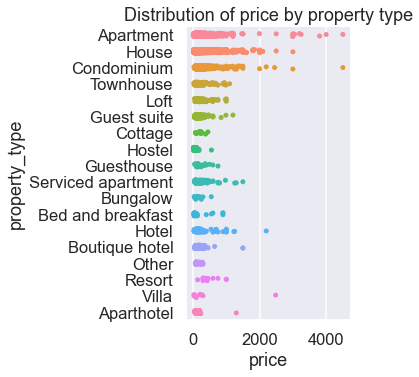

Note: property_types with fewer than 10 observations have been removed


In [1]:
## Preprocessing

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

data = pd.read_csv('rentals.csv')

data.head()

# Convert price column to numerical datatype
data.price = data.price.str.strip('$')
data.price = data.price.str.replace(',','').astype(float)

## Cleaning

# Remove extreme prices
data = data[data.price < 5000]

# Removing property_type with fewer than 10 observations (poor statistics)
df = data.property_type.value_counts()
bad_categories = df[df < 10].index
data = data[~data.property_type.isin(bad_categories)]

# Remove 16 NaN observations
data = data[~data.isnull().any(axis=1)]

# Remove 1 observation with 0 price
#print(len(data[data['price'] == 0]))
data = data[data['price'] > 0]

# Change number of bathrooms to 1 when 0 for Boutique hotel, Hotel rooms
#display(data[data.bathrooms == 0])
condition = ((data.property_type == 'Boutique hotel') & (data.room_type == 'Hotel room')) & (data.bathrooms == 0)
index = data[condition]['bathrooms'].index
data.loc[index, 'bathrooms'] = 1.0

# Remove entire apartment with no bathrooms (keep 0 bathrooms for Private rooms and Shared rooms)
condition = (data.room_type == 'Entire home/apt') & (data.bathrooms == 0)
data = data[~condition]

# Remove property with 14 bedrooms (private room with 14 bedrooms and bathrooms)
data = data[~(data.bedrooms == 14)]

## Feature engineering

# Add new features to account for interaction of latitude, longitude and bedrooms
data['lat_long'] = data.latitude * data.longitude
data['lat_rooms'] = data.latitude * data.bedrooms
data['long_rooms'] = data.longitude * data.bedrooms

## EDA
sns.set()
sns.set_context('talk')

# Display distribution of price data by property_type
sns.catplot(data=data, x='price', y='property_type', kind='strip')
plt.title('Distribution of price by property type')
plt.show()

print('Note: property_types with fewer than 10 observations have been removed')

### Even restricting to prices to less than $1000/night, <br> the bulk of the data is for low price accommodations

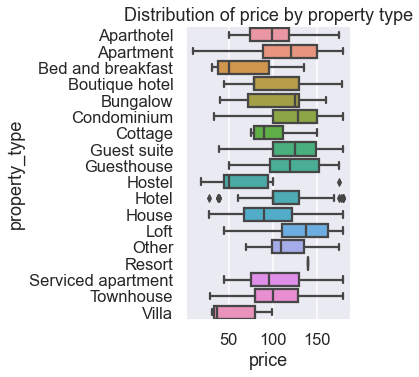

In [7]:
# Remove moderately extreme prices
cutoff = 180
data = data[data.price < cutoff]

# Display distribution of price data by property_type
sns.catplot(data=data, x='price', y='property_type', kind='box')
plt.title('Distribution of price by property type')
plt.show()

## Modeling and Prediction

### What if we construct a model for this data?

#### We want an error (RMSE, MAE) less than $25

RMSE is essentially the average error <br>
MAE is essentially the average error for the bulk of the data

In [8]:
## Model construction

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Convert property_type and room_type to categorical datatype
data.property_type = data.property_type.astype('category')
data.room_type = data.room_type.astype('category')

# Get categorical and numerical column names, and only the numerical predictor variables
cat_cols = data.select_dtypes(include = 'category').columns
num_cols = data.drop('id',axis=1).select_dtypes(include = 'number').columns
num_pred_cols = data.drop(['id', 'price'],axis=1).select_dtypes(include = 'number').columns

# Functions to extract categorical and numerical data from the input dataset
get_cat_data = FunctionTransformer(lambda x: x[cat_cols], validate=False)
get_num_data = FunctionTransformer(lambda x: x[num_pred_cols], validate=False)

# Pipelines to preprocess categorical and numerical data separately
cat_pipeline = Pipeline([('selector', get_cat_data),
                         ('encoder', OneHotEncoder())])
num_pipeline = Pipeline([('selector', get_num_data)])

# Regression algorithm
regressor = GradientBoostingRegressor(loss='huber',
                                      learning_rate=0.2,
                                      n_estimators=200,
                                      criterion='mse', 
                                      random_state=12)

# Full modeling pipeline
pipeline = Pipeline([('union', FeatureUnion([('categorical', cat_pipeline),
                                             ('numerical', num_pipeline)])),
                     ('regressor', regressor)])

predictors = data.drop('price', axis=1)
target = data['price']
    
X_train, X_test, y_train, y_test = train_test_split(predictors, target, 
                                                    random_state=14, 
                                                    test_size=0.15)

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print('Model R^2 score:',pipeline.score(X_test, y_test))

print('Model RMSE:',np.sqrt(mean_squared_error(predictions,y_test)))
print('Model MAE:',mean_absolute_error(predictions,y_test))

Model R^2 score: 0.5744820515223082
Model RMSE: 24.689512244676177
Model MAE: 19.16043311840067


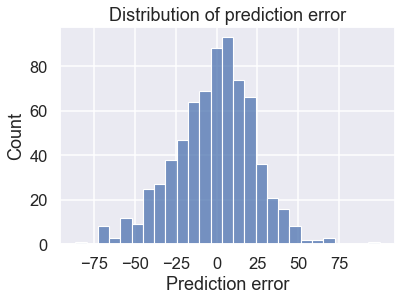

In [9]:
# Plot distribution of prediction error
sns.histplot(predictions - y_test)
plt.title('Distribution of prediction error')
plt.xlabel('Prediction error')
if cutoff < 200:
    plt.xticks([-75, -50, -25, 0, 25, 50, 75])
plt.show()

### The higher the actual price, the more we under-predict the value

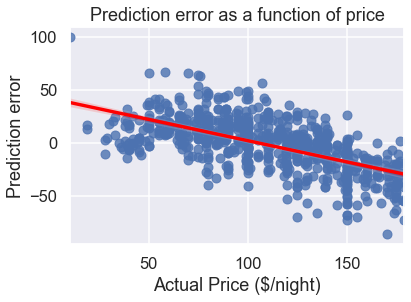

In [10]:
# Plot prediction error as a function of price
if cutoff < 200:
    sns.regplot(y_test, predictions - y_test, line_kws={'color':'red'})
else:
    sns.scatterplot(y_test, predictions - y_test)
plt.title('Prediction error as a function of price')
plt.xlabel('Actual Price ($/night)')
plt.ylabel('Prediction error')
plt.show()

### Observation: Prediction error should be random, but shows clear downward trend

### Conclusion: The features in our dataset are not accounting for the variation in prices

## Addressing the Limitations

### The lack of high price data is not consistent across all categories

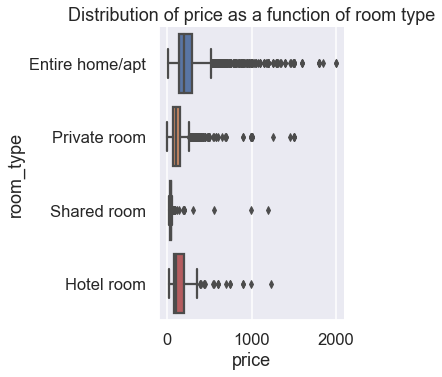

In [11]:
data2 = pd.read_csv('data/rentals.csv')

# Convert price column to numerical datatype
data2.price = data2.price.str.strip('$')
data2.price = data2.price.str.replace(',','').astype(float)

data2 = data2[data2.price < 2000]

sns.catplot(data=data2, x='price', y='room_type', kind='box')
plt.title('Distribution of price as a function of room type')
plt.show()

### So we could build different predictors based on room type category

### But the same general problems remain:

    * there is not enough high price data
    * the available features do not distinguish high from low price properties

## Conclusion

### Problem: Predict rental price per night of wide range of room rentals within $25

### Challenge: Large number of property types, many with limited data

### Approach:

    1. What conditions allow predictions within $25?
    2. How can we relax these conditions?
    
### Result: 

    1. Can accurately predict price for rentals under $180/night

    2. For anything over $180/night:
    
        * need to invest in more data
        * need to identify features that correlate to high price rentals
        * need to analyze geographical information to better correlate to price